In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# data is stored in data in the root folder
import numpy as np
import torch

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.mps.is_available():
    torch.mps.manual_seed(SEED)
    # torch.mps.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

(224, 224, 3)


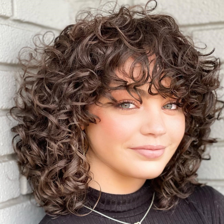

In [3]:
from PIL import Image
import numpy as np

# Load an image
img = Image.open(
    "../../data/07-deep-learning/train/curly/1-curly-hair-with-bangs-CYFg6l_Ls4-.jpg"
)

# Resize to target size
img = img.resize((224, 224))

# Convert to numpy array
x = np.array(img)
print(x.shape)  # (224, 224, 3)
display(img)

## Define dataloader

In [4]:
from pathlib import Path
from torch.utils.data import Dataset


class HairDataset(Dataset):
    def __init__(self, data_dir: Path, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        self.classes = sorted([x.name for x in self.data_dir.iterdir() if x.is_dir()])
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        self.samples = [
            (img_path, self.class_to_idx[img_path.parent.name])
            for class_dir in self.data_dir.iterdir()
            if class_dir.is_dir()
            for img_path in class_dir.iterdir()
            if img_path.is_file()
        ]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

## define model

In [5]:
from torch import nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=1):
        super(CNN, self).__init__()

        # Convolutional layer: 3 -> 32 channels, 3x3 kernel
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3)

        # Max pooling layer: 2x2
        self.pool = nn.MaxPool2d(kernel_size=2)

        # After conv: (3, 200, 200) -> (32, 198, 198)
        # After pool: (32, 198, 198) -> (32, 99, 99)
        # Formula: output_size = (input_size - kernel_size + 2*padding) / stride + 1
        # Flattened size: 32 * 99 * 99 = 313,632
        self.fc1 = nn.Linear(in_features=32 * 99 * 99, out_features=64)

        # Output layer with 1 neuron for binary classification
        self.output_layer = nn.Linear(in_features=64, out_features=num_classes)

    def forward(self, x):
        # Conv + ReLU
        x = self.conv(x)
        x = F.relu(x)

        # Max pooling
        x = self.pool(x)

        # Flatten
        x = torch.flatten(x, 1)

        # Hidden layer + ReLU
        x = self.fc1(x)
        x = F.relu(x)

        # Output layer (sigmoid is in BCEWithLogitsLoss)
        x = self.output_layer(x)
        return x


# Question 1

## Which loss function you will use?
`BCEWithLogitsLoss`

In [6]:
from torch.optim import SGD

device = torch.device(
    (
        "cuda"
        if torch.cuda.is_available()
        else ("mps" if torch.mps.is_available() else "cpu")
    )
)
print(f"using {device}")

model = CNN(in_channels=3, num_classes=1)
model.to(device)

optimizer = SGD(params=model.parameters(), lr=0.002, momentum=0.8)

# combines sigmoid + BCE and is numerically more stable
criterion = nn.BCEWithLogitsLoss()

using mps


# What's the total number of parameters of the model?

In [7]:
sum([p.numel() for p in model.parameters()])

20073473

In [8]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split

train_transforms = transforms.Compose(
    [
        transforms.Resize((200, 200)),
        transforms.ToTensor(),
        # ImageNet normalization
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# full_train_dataset = HairDataset(
#     data_dir=Path("../../data/07-deep-learning/train"),
#     transform=train_transforms,
# )
# train_size = int(0.8 * len(full_train_dataset))
# val_size = len(full_train_dataset) - train_size

# # split the train dataset into train and validation
# train_dataset, val_dataset = random_split(
#     dataset=full_train_dataset, lengths=[train_size, val_size]
# )
train_dataset = HairDataset(
    data_dir=Path("../../data/07-deep-learning/train"),
    transform=train_transforms,
)

# create the loaders; use the same transforms for all of them
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False)

test_dataset = HairDataset(
    data_dir=Path("../../data/07-deep-learning/train"), transform=train_transforms
)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

In [9]:
num_epochs = 10
history = {"acc": [], "loss": []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history["loss"].append(epoch_loss)
    history["acc"].append(epoch_acc)

    print(
        f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}"
    )

Epoch 1/10, Loss: 0.6907, Acc: 0.5980
Epoch 2/10, Loss: 0.5838, Acc: 0.6954
Epoch 3/10, Loss: 0.5312, Acc: 0.7116
Epoch 4/10, Loss: 0.4919, Acc: 0.7516
Epoch 5/10, Loss: 0.4555, Acc: 0.7865
Epoch 6/10, Loss: 0.5218, Acc: 0.7328
Epoch 7/10, Loss: 0.4112, Acc: 0.7990
Epoch 8/10, Loss: 0.3764, Acc: 0.8140
Epoch 9/10, Loss: 0.3469, Acc: 0.8439
Epoch 10/10, Loss: 0.2831, Acc: 0.8814


# What is the median of training accuracy for all the epochs for this model?

In [10]:
np.median(history["acc"])

np.float64(0.7690387016229713)

In [11]:
# What is the standard deviation of training loss for all the epochs for this model?
np.std(history["loss"])

np.float64(0.11449442089749948)

In [19]:
abs(0.11449442089749948 - 0.078) < abs(0.11449442089749948 - 0.171)

True

# Data Augmentation

In [12]:
train_transforms_2 = transforms.Compose(
    [
        transforms.Resize((200, 200)),
        transforms.ToTensor(),
        # ImageNet normalization
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomRotation(50),
        transforms.RandomResizedCrop(200, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
        transforms.RandomHorizontalFlip(),
    ]
)

In [13]:
####
# train for 10 more epochs
####
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        # Ensure labels are float and have shape (batch_size, 1)
        labels = labels.float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        # For binary classification with BCEWithLogitsLoss, apply sigmoid to outputs before thresholding for accuracy
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history["loss"].append(epoch_loss)
    history["acc"].append(epoch_acc)

In [14]:
# After training with augmentation, evaluate on test set each epoch
history_aug = {"test_acc": [], "test_loss": []}

# During/after each epoch, evaluate on test:
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_epoch_loss = test_loss / len(test_dataset)
test_epoch_acc = correct / total
history_aug["test_loss"].append(test_epoch_loss)
history_aug["test_acc"].append(test_epoch_acc)

In [15]:
np.mean(history_aug['test_loss'])

np.float64(0.035965724870302106)

In [16]:
np.mean(history_aug['test_acc'][-5:])

np.float64(0.9987515605493134)